In [1]:
import os
import sys

sys.path.append("/home/ec2-user/marineHeatWaves")
import marineHeatWaves as mh

import xarray as xr
import numpy as np

from dask.distributed import Client

from datetime import date, datetime

from functools import partial

import gcsfs

import cartopy.crs as ccrs
import cartopy.feature as cf

from pandas import Timestamp

import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Pool

from numba import float64, guvectorize, jit

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

In [2]:
from importlib import reload

In [3]:
client = Client()

# Marine Heatwaves in OISST Data

via  [`marineHeatWaves.py`](https://github.com/ecjoliver/marineHeatWaves/blob/master/marineHeatWaves.py)


In [4]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [6]:
oisst

,Array,Chunk
Bytes,56.55 GB,10.00 MB
Shape,"(13636, 720, 1440)","(100, 50, 500)"
Count,14386 Tasks,8220 Chunks
Type,float32,numpy.ndarray


In [5]:
oisst.sst.data

,Array,Chunk
Bytes,56.55 GB,10.00 MB
Shape,"(13636, 720, 1440)","(100, 50, 500)"
Count,14386 Tasks,8220 Chunks
Type,float32,numpy.ndarray


In [7]:
oisst

,Array,Chunk
Bytes,56.55 GB,10.00 MB
Shape,"(13636, 720, 1440)","(100, 50, 500)"
Count,14386 Tasks,8220 Chunks
Type,float32,numpy.ndarray


In [10]:
# s
PNW_LAT = slice(40, 50)
PNW_LON = slice(-165.9, -121.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).compute()

In [11]:
oisst_pnw.sst.data

array([[[19.01     , 19.05     , 19.06     , ...,        nan,
                nan,        nan],
        [18.859999 , 18.88     , 18.96     , ...,        nan,
                nan,        nan],
        [18.59     , 18.63     , 18.71     , ...,        nan,
                nan,        nan],
        ...,
        [12.5199995, 12.55     , 12.65     , ...,        nan,
                nan,        nan],
        [12.17     , 12.15     , 12.219999 , ...,        nan,
                nan,        nan],
        [11.719999 , 11.639999 , 11.66     , ...,        nan,
                nan,        nan]],

       [[19.65     , 19.529999 , 19.41     , ...,        nan,
                nan,        nan],
        [19.48     , 19.359999 , 19.3      , ...,        nan,
                nan,        nan],
        [19.24     , 19.119999 , 19.05     , ...,        nan,
                nan,        nan],
        ...,
        [12.349999 , 12.469999 , 12.639999 , ...,        nan,
                nan,        nan],
        [11.

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


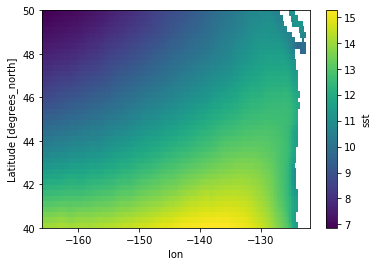

In [13]:

oisst_pnw.sst.mean('time').plot()

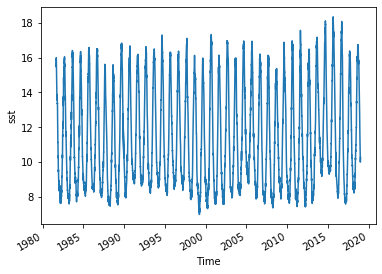

In [14]:
oisst_pnw.sst.mean(['lat', 'lon']).plot()

In [16]:
def mhw_1d(temps, time):
    if(np.isnan(temps).any()): return xr.DataArray(
        np.full_like(temps, np.nan), 
        name = 'mhw', 
        dims = 'time', 
        coords ={
            'time': time
        }
    )

    ordinals =  np.array([Timestamp(t).toordinal() for t in time])
    dets = mh.detect(ordinals, temps.copy())
    events = dets[0]['n_events']
    del dets[0]['n_events']
    
    arrays = {
        key: xr.DataArray(np.full_like(time, 0., dtype='float64'),
                          name = key, dims='time',
                          coords={
                              'time' : time,
                          })
        for key in ['mhw_cum_intensity']
    }
    
    for event in range(events):
        start_date = dets[0]['date_start'][event]
        end_date = dets[0]['date_end'][event]
        cum_intense = dets[0]['intensity_cumulative'][event]

#         arrays['mhw'].loc[dict(time=slice(start_date, end_date))] = True
        arrays['mhw_cum_intensity'].loc[dict(time=slice(start_date, end_date))] = cum_intense
        
#     clim = xr.DataArray(dets[1]['thresh'], name='clim_thresh', dims='time', coords={'time': time})
        
    return (arrays['mhw_cum_intensity'])

In [17]:
a = xr.apply_ufunc(
    mhw_1d, 
    oisst_pnw.sst.chunk({'lat': 1, 'lon': 1, 'time': -1}), 
    oisst_pnw.time, 
    input_core_dims = [['time'], ['time']],
    output_core_dims=[["time"]], 
    vectorize=True, 
    dask='parallelized', 
    output_dtypes=['float64']
)

In [19]:
a.data


,Array,Chunk
Bytes,767.98 MB,109.09 kB
Shape,"(40, 176, 13636)","(1, 1, 13636)"
Count,21122 Tasks,7040 Chunks
Type,float64,numpy.ndarray


In [20]:
ans = a.compute()

KeyboardInterrupt: 

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:38874 remote=tcp://127.0.0.1:39661>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:38876 remote=tcp://127.0.0.1:39661>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:38878 remote=tcp://127.0.0.1:39661>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:38880 remote=tcp://127.0.0.1:39661>
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [17]:
ans.to_netcdf("pnw_mhw_intensity.nc")

In [ ]:
sels = ans.isel(lat=25, lon=20)
fig = plt.figure(figsize=(15, 5))

plt.vlines(sels.time[sels].values, 0, 10, color='red', )
plt.plot()

In [ ]:
sels = ans.isel(lat=5, lon=20)

import matplotlib.transforms as mt

fig, ax = plt.subplots(figsize=(15, 5))
sst = oisst_pnw.sel(lat=sels.lat.values, lon=sels.lon.values).persist().sst 
ax.vlines(sels.time[sels].values, 0, 10, color='red', alpha=0.2,  transform = trans)

ax.plot(sst.time, sst)
trans = mt.blended_transform_factory(ax.transData, ax.transAxes)






In [ ]:
sst = oisst_pnw.sel(lat=sels.lat.values, lon=sels.lon.values).sst 
plt.plot(sst.time, sst)

In [ ]:
se

In [ ]:
sels

In [ ]:
sel

In [ ]:
# s
PNW_LAT = slice(44.5, 46.5)
PNW_LON = slice(165.5, 166)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).load()

In [ ]:
oisst_pnw

In [ ]:
a = xr.apply_ufunc(
    mhw_1d, 
    oisst_pnw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}).load(), 
    oisst_pnw.time.load(), 
    input_core_dims = [['time'], ['time']],
    output_core_dims=[["time"], ["time"]], 
    vectorize=True, 
    output_dtypes=['bool']
)

In [ ]:
ans = a.compute()